# Actividad 2

# Controlador en esquema de Espacio de estados.

El objetivo de este trabajo es realizar un controlador pero en este caso partiendo de la base de un esquema de ESPACIO DE ESTADOS.

## Caso 1 - Motor CC

Partiendo de las ecuaciones de motor y parametros calculados en el trabajo practico anterior

$   LAA=7.14e-04 ;
    J=3.1210e-06; 
    Ra=27; 
    B=0; 
    Ki=16.5 
    Km= 0.0606
$


Modelado por las siguientes Ecuaciones diferenciales:

$\frac{di_a}{dt}=\frac{R_A}{L_{AA}}ia-\frac{K_m}{L_{AA}}\omega _r+\frac{1}{L_{AA}}Va $

$ \frac{d\omega_r}{dt}=\frac{K_i}{J}ia-\frac{B_m}{J}\omega _r+\frac{1}{J}T_L $

$ \frac{d\theta _t}{dt}=\omega _r $


Podiamos modelar un controlador PID obteniendo sus constantes como : Ki=0.01 ;  Kp0.5 ; Kd=1


### Espacio de estados

In [40]:
# Importacion de librerias

import numpy as np
import control as ct
import math
import pandas as pd
import matplotlib.pyplot as plt
from control.matlab import *
import cmath as cm
from math import log
import sympy as sp
from scipy import signal


A partir de las ecuaciones diferenciales modelamos en espacio de estados. Reescribiendo las ecuaciones en matrices y llevando a espacio de estados

In [41]:
# Definir los parámetros del sistema
R_A =27
L_AA =7.14e-4
K_m = 0.0606
J = 3.12e-6
B_m = 0
K_i = 0.0102

## Definir las matrices del sistema de espacio de estados
A = np.array([[-R_A / L_AA, -K_m / L_AA, 0],
              [K_i / J, -B_m / J, 0],
              [0, 1, 0]])

B = np.array([[1 / L_AA],
              [0],
              [0]])

C = np.array([[0, 0, 1]])

D = np.array([[0]])
print('A:', A)
print('B:', B)
print('C:', C)
print('D:', D)

# Crear el sistema de espacio de estados
#sys= ss(A, B, C, D)
sys = signal.StateSpace(A, B, C,D)
tf = sys.to_tf()
print("Función de transferencia:")
print(tf)
#sys_tf=ct.ss2tf(sys)
#print('sys_tf:', sys_tf)

# Función de transferencia



A: [[-3.78151261e+04 -8.48739496e+01  0.00000000e+00]
 [ 3.26923077e+02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]]
B: [[1400.56022409]
 [   0.        ]
 [   0.        ]]
C: [[0 0 1]]
D: [[0]]
Función de transferencia:
TransferFunctionContinuous(
array([5.65814844e-08, 4.57875458e+05]),
array([1.00000000e+00, 3.78151261e+04, 2.77472527e+04, 0.00000000e+00]),
dt: None
)


## Obvservabilidad

Determino si el sistema es observable. Debo construir la matriz de obvservabilidad. La cual es la siguiente:

$\begin{bmatrix}
C\\
CA 
\\
CA^{n-1} 
\end{bmatrix}$

Calculo su rango , si el rango de es igual al numero de estados de el sisema , entonces el sistema es obvservable

In [42]:
n = A.shape[0] #numero de estados
O = np.vstack([C @ np.linalg.matrix_power(A, i) for i in range(n)])
print('Matriz de observabilidad:\n', O)
range_O = np.linalg.matrix_rank(O)
print('Rango de la matriz de observabilidad:', range_O)
# Verificar observabilidad
if range_O == n:
    print("El sistema es completamente observable.")
else:
    print("El sistema no es completamente observable.")


Matriz de observabilidad:
 [[  0.           0.           1.        ]
 [  0.           1.           0.        ]
 [326.92307692   0.           0.        ]]
Rango de la matriz de observabilidad: 3
El sistema es completamente observable.


## Controlabilidad
Determino si el sistema es observable. Debo construir la matriz de obvservabilidad. La cual es la siguiente:

$\begin{bmatrix}
A &AB  &A^{n-1}B 
\end{bmatrix}$

Calculo su rango , si el rango de es igual al numero de estados de el sisema , entonces el sistema es controlable


In [43]:
# Calcular la matriz de controlabilidad
n = A.shape[0]  # Número de estados
C_ctrl = np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n)])

print('Matriz de controlabilidad:\n', C_ctrl)
range_C_ctrl = np.linalg.matrix_rank(C_ctrl)
print('Rango de la matriz de controlabilidad:', range_C_ctrl)

# Verificar controlabilidad
if range_C_ctrl == n:
    print("El sistema es completamente controlable.")
else:
    print("El sistema no es completamente controlable.")


Matriz de controlabilidad:
 [[ 1.40056022e+03 -5.29623614e+07  2.00273951e+12]
 [ 0.00000000e+00  4.57875458e+05 -1.73146182e+10]
 [ 0.00000000e+00  0.00000000e+00  4.57875458e+05]]
Rango de la matriz de controlabilidad: 3
El sistema es completamente controlable.


## Tiempo de simulacion e integración

In [44]:
# Definir el tiempo de simulación y tiempo de integración
#Tiempo de integracion de euler -> obtener polos lazo abierto

poles= np.linalg.eigvals(A)
print('Polos:', poles)

#El polo mayor es 0 pero no es parte de la dinamica de el sistema(indica no estabilidad)
dominant_complex_pole = poles[1]  # Se elige uno de los polos complejos conjugados

#Tiempo intrgracion de euler
tR = np.log(0.95) / np.abs(dominant_complex_pole.real)
print('Tiempo de integración de Euler:', tR)

#Tiempo de simulacion

Polos: [ 0.00000000e+00 -7.33774922e-01 -3.78143923e+04]
Tiempo de integración de Euler: -0.06990330800476798


## Asignacion de polos

Habiendo obtenido la funcion de transferencia del sistema

$G(s) = \frac{s^2 - 2.77708750 \times 10^{-7}s + 4.57875458 \times 10^6}{1.00000000s^3 + 3.78151261 \times 10^4s^2 + 2.77472527 \times 10^5s + 2.18278728 \times 10^{-11}}$

Coincide el orden del numerador con la cantidad de estados

In [45]:
# Calcular los polos del sistema abierto
poles_LA= np.linalg.eigvals(A)
print("Polos del sistema abierto:", poles_LA)  
## Polos del sistema abierto -> (0,-7.339,-3.78e+4)


#Forma canonica controlable

#Aplico Ackermann

# Convertir el sistema a su forma controlable
T = ct.ctrb(A, B)
T_inv = np.linalg.inv(T)
Ac = T_inv @ A @ T
Bc = T_inv @ B

# Especificar los polos deseados
polos_deseados = [-1.5, -2, -20000]

# Calcular las ganancias del controlador utilizando el método de Ackermann
K = ct.acker(Ac, Bc, polos_deseados)

print("Ganancias del controlador (Ackermann):")
print(K)



Polos del sistema abierto: [ 0.00000000e+00 -7.33774922e-01 -3.78143923e+04]
Ganancias del controlador (Ackermann):
[[-1.78116261e+04  6.73591140e+08 -2.54714396e+13]]


In [46]:
K= np.array([[-1.78116261e+04, 6.73341415e+08,-2.54575482e+13]])
# Definir el sistema de lazo cerrado
Ac = A - B @ K
Bc = B
Cc = C
Dc = D


## Terminar simulacion

## LQR

In [47]:
#implementacion controlador LQR

#NO FUNCIONA VERSION DE SLYCOT, en collab funciona y obtuve K



# Definir las matrices de ponderación Q y R
#Q = np.diag([6.25, 2.5e-5, 1, 10000])  # Ponderaciones de estado
#R = np.array([[100]])                  # Ponderaciones de entrada
# Ampliar la matriz A
#A_ampliada = np.hstack([A, np.zeros((A.shape[0], 1))])

#A_ampliada = np.vstack([A_ampliada, np.hstack([-C, np.zeros((1, 1))])])

# Ampliar la matriz B
#B_ampliada = np.vstack([B, np.zeros((1, B.shape[1]))])


# Resolver la ecuación de Riccati para obtener la matriz P
#P = solve_continuous_are(A_ampliada, B_ampliada, Q, R) # type: ignore

# Calcular la ganancia del controlador LQR
#K = np.linalg.inv(R).dot(B_ampliada.T).dot(P)

# Imprimir la ganancia del controlador
#print("Ganancia del controlador K:")
#print(K)

# Imprimir las dimensiones de las matrices ampliadas
#print("Dimensiones de A_ampliada:", A_ampliada.shape)
#print("Dimensiones de B_ampliada:", B_ampliada.shape)


# Calcular la ganancia del controlador LQR
##K, _, _ = ct.lqr(A_ampliada, B_ampliada, Q, R) 

# Imprimir la ganancia del controlador
#print("Ganancia del controlador K:")
#print(K)

#NO FUNCIONA VERSION DE SLYCOT, en collab funciona y obtuve K



## Simulacion


## Referencia y torque

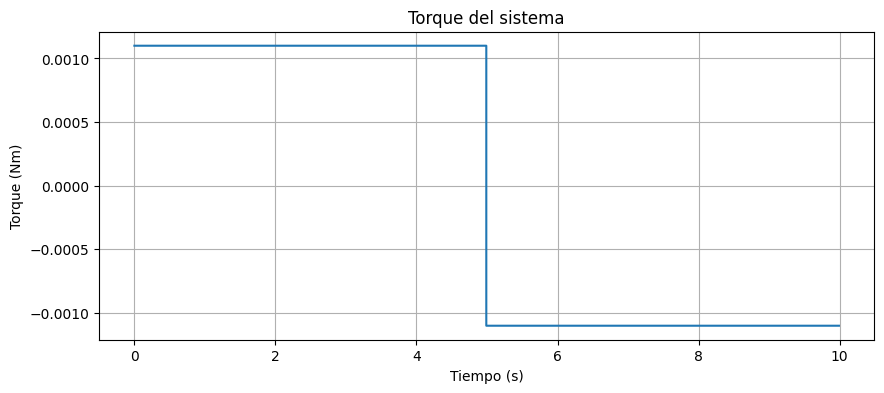

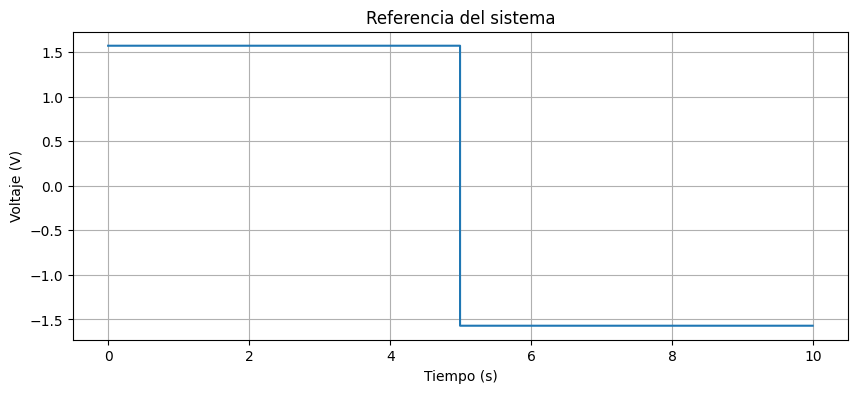

In [48]:
# Definir el tiempo de integración y simulación
h = 0.01  # Intervalo de tiempo de integración
simTime = 10
  # Tiempo total de simulación
t = np.arange(0, simTime, h)

# Frequency of the signal
frequency = 0.1  # Frequency of the signal in Hz (every 10 seconds)

# Generate square signal with sign change every 5 seconds
reference = np.pi/2 * signal.square(2 * np.pi * frequency * t, duty=0.5)

# Definir el torque de entrada
torque_reference = 1.1e-3 * signal.square(2 * np.pi * frequency * t, duty=0.5)

#visualizacion torque
plt.figure(figsize=(10, 4))
plt.plot(t, torque_reference, drawstyle='steps-pre')
plt.title('Torque del sistema')
plt.xlabel('Tiempo (s)')
plt.ylabel('Torque (Nm)')
plt.grid(True)
plt.show()

# Visualize the input signal
plt.figure(figsize=(10, 4))
plt.plot(t, reference, drawstyle='steps-pre')
plt.title('Referencia del sistema')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje (V)')
plt.grid(True)
plt.show()

/tmp/ipykernel_18616/1931124224.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeta[i] = integ + zetaP * h
/tmp/ipykernel_18616/1931124224.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i] = -np.dot(K[:, :3], stateVector.T) - K[:, 3] * zeta[i]


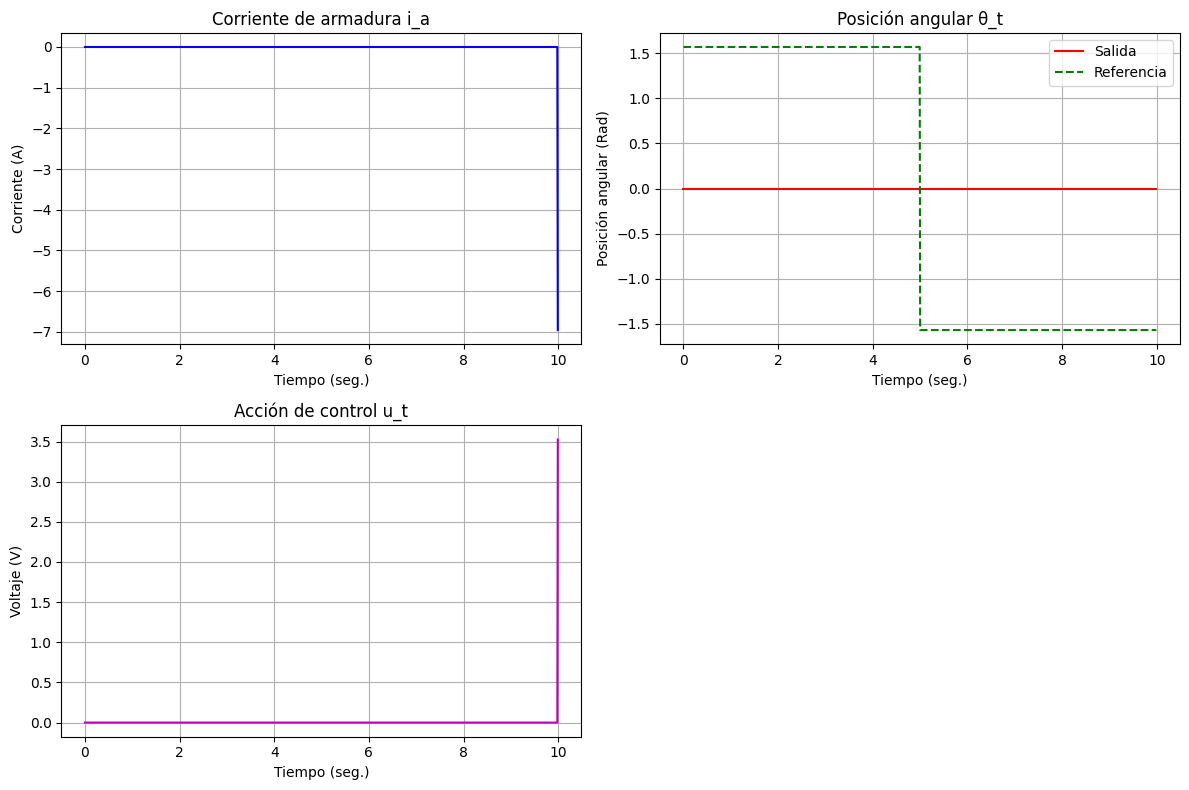

In [66]:

# Ganancia del controlador K
#K=np.array([[ 0.01229001, 0.128803, 1.9488612,-10]])

#K=np.array([[ 0.1791 , 0.0018, 1.9874,-31.6228]])


K=np.array([[ 1.92422762e-02 , 2.07660098e-01, 4.12022552e+00,-3.16227766e+01]])


# Condiciones iniciales
ia = np.zeros(len(t))
w = np.zeros(len(t))
tita = np.zeros(len(t))
u = np.zeros(len(t))
zeta = np.zeros(len(t))

# Estado inicial
x = np.array([ia[0], w[0], tita[0]])
stateVector = np.transpose(np.array([ia[0], w[0], tita[0]]))
integ = 0

# Simulación del sistema
for i in range(len(t)):
    # Calcular la señal de error
    zetaP = reference[i] - np.dot(C, stateVector)
    
    # Calcular la integral del error
    zeta[i] = integ + zetaP * h
    
    # Calcular la acción de control
    u[i] = -np.dot(K[:, :3], stateVector.T) - K[:, 3] * zeta[i]
    
    # Limitar la acción de control
    u[i] = np.clip(u[i], -24, 24)
    
# Actualizar los estados del sistema
x1P = ((-R_A * x[0]) / (L_AA+ K_m * x[1])/ L_AA + u[i]/ L_AA) 
x2P = ((K_i * x[0] )/ J - B_m * x[1]  / J- torque_reference[i] / J) 
x3P = x[1]
xP = np.array([x1P, x2P, x3P])

stateVector = np.transpose(np.array([ia[0], w[0], tita[0]]))

x = x + h * xP


# Actualizar los valores de las variables
ia[i] = x[0]
w[i] = x[1]
tita[i] = x[2]
integ = zeta[i]

# Graficar los resultados
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(t, ia, 'b', linewidth=1.5)
plt.title('Corriente de armadura i_a')
plt.xlabel('Tiempo (seg.)')
plt.ylabel('Corriente (A)')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(t, tita, 'r', linewidth=1.5, label='Salida')
plt.plot(t, reference, 'g--', linewidth=1.5, label='Referencia')
plt.title('Posición angular θ_t')
plt.xlabel('Tiempo (seg.)')
plt.ylabel('Posición angular (Rad)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(t, w, 'm', linewidth=1.5)
plt.title('Acción de control u_t')
plt.xlabel('Tiempo (seg.)')
plt.ylabel('Voltaje (V)')
plt.grid()

plt.tight_layout()
plt.show()




/tmp/ipykernel_18616/2604784046.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeta[i] = integ + zetaP * h
/tmp/ipykernel_18616/2604784046.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i] = -np.dot(K[:, :3], stateVector.T) - K[:, 3] * zeta[i]
/tmp/ipykernel_18616/2604784046.py:83: RuntimeWarning: overflow encountered in scalar divide
  x2P = (Ki * x[0] - Bm * x[1] - torque_reference[i]) / J
/tmp/ipykernel_18616/2604784046.py:83: RuntimeWarning: invalid value encountered in scalar multiply
  x2P = (Ki * x[0] - Bm * x[1] - torque_reference[i]) / J


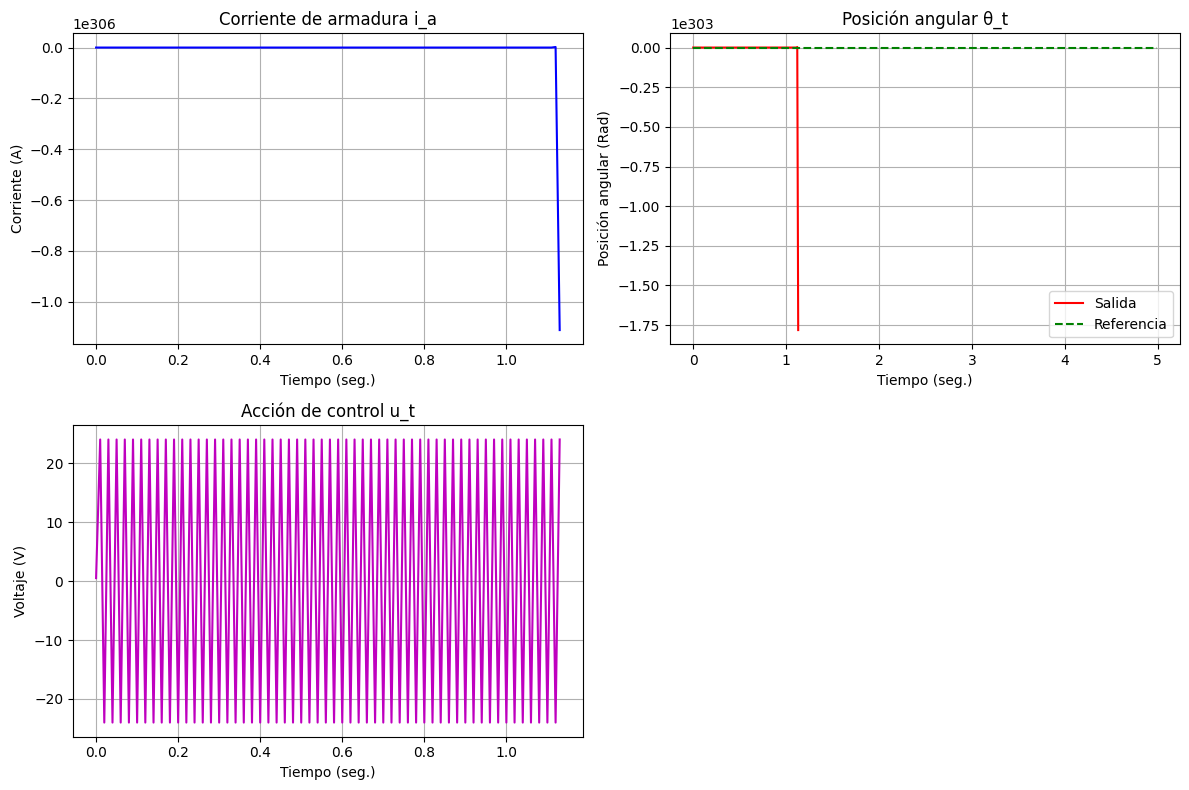

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Parámetros del sistema
Ra = 20
Laa = 4.9736e-04
Km = 0.0605
J = 2.5518e-09
Bm = 0
Ki = 0.0102

# Definir las matrices del sistema
A = np.array([[-Ra/Laa, -Km/Laa, 0],
              [Ki/J, -Bm/J, 0],
              [0, 1, 0]])

B = np.array([[1/Laa],
              [0],
              [0]])

C = np.array([[0, 0, 1]])

# Sistema de espacio de estados
sys = (A, B, C)

# Diseño del controlador LQR
#implementacion controlador LQR
# Definir las matrices de ponderación Q y R
Q = np.diag([10, 0.01, 1,100000])  # Ponderaciones de estado
R = np.array([[100]])                  # Ponderaciones de entrada
# Ampliar la matriz A
A_ampliada = np.hstack([A, np.zeros((A.shape[0], 1))])

A_ampliada = np.vstack([A_ampliada, np.hstack([-C, np.zeros((1, 1))])])

# Ampliar la matriz B
B_ampliada = np.vstack([B, np.zeros((1, B.shape[1]))])


# Calcular la ganancia del controlador LQR
#K, _, _ = ct.lqr(A_ampliada, B_ampliada, Q, R)

K=np.array([[ 1.92422762e-02 , 2.07660098e-01, 4.12022552e+00,-3.16227766e+01]])
# Definir el tiempo de integración y simulación
h = 0.01
simTime = 5
t = np.arange(0, simTime, h)

# Señal de referencia y torque de entrada
frequency = 0.1
reference = (np.pi/2) * signal.square(2 * np.pi * (1/5) * t, duty=0.5)
torque_reference = (1.1e-3 / 2) * signal.square(2 * np.pi * (1/5) * t) + (1.1e-3 / 2)

# Condiciones iniciales
ia = np.zeros(len(t))
w = np.zeros(len(t))
tita = np.zeros(len(t))
u = np.zeros(len(t))
zeta = np.zeros(len(t))

# Estado inicial
x = np.array([ia[0], w[0], tita[0]])
stateVector = np.array([ia[0], w[0], tita[0]])
integ = 0

# Simulación del sistema
for i in range(len(t)):
    # Calcular la señal de error
    zetaP = reference[i] - np.dot(C, stateVector)
    
    # Calcular la integral del error
    zeta[i] = integ + zetaP * h
    
    # Calcular la acción de control
    u[i] = -np.dot(K[:, :3], stateVector.T) - K[:, 3] * zeta[i]
    
    # Limitar la acción de control
    u[i] = np.clip(u[i], -24, 24)
    
    # Actualizar los estados del sistema
    x1P = (-Ra * x[0] + Km * x[1] + u[i]) / Laa
    x2P = (Ki * x[0] - Bm * x[1] - torque_reference[i]) / J
    x3P = x[1]
    
    # Actualizar el vector de estado
    x = x + h * np.array([x1P, x2P, x3P])
    
    # Actualizar el vector de estado
    stateVector = x.copy()
    
    # Actualizar los valores de las variables
    ia[i], w[i], tita[i] = x

    # Actualizar la integral del error
    integ = zeta[i]

    # Limitar la acción de control
    if u[i] > 24:
        u[i] = 24
    elif u[i] < -24:
        u[i] = -24

       

# Graficar los resultados
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(t, ia, 'b', linewidth=1.5)
plt.title('Corriente de armadura i_a')
plt.xlabel('Tiempo (seg.)')
plt.ylabel('Corriente (A)')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(t, tita, 'r', linewidth=1.5, label='Salida')
plt.plot(t, reference, 'g--', linewidth=1.5, label='Referencia')
plt.title('Posición angular θ_t')
plt.xlabel('Tiempo (seg.)')
plt.ylabel('Posición angular (Rad)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(t, u, 'm', linewidth=1.5)
plt.title('Acción de control u_t')
plt.xlabel('Tiempo (seg.)')
plt.ylabel('Voltaje (V)')
plt.grid()

plt.tight_layout()
plt.show()

/tmp/ipykernel_18616/3817499456.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeta[i] = integ + zetaP * h
/tmp/ipykernel_18616/3817499456.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i] = -np.dot(K[:, :3], stateVector.T) - K[:, 3] * zeta[i]


Text(0, 0.5, 'Corriente (A)')

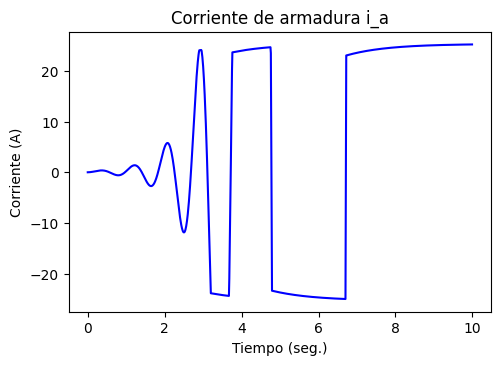

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Definir los parámetros del motor DC
R_A = 1.0  # Resistencia de la armadura (Ohm)
L_AA = 0.01  # Inductancia de la armadura (Henry)
K_m = 0.005  # Constante del motor (Nm/A)
J = 0.001  # Momento de inercia del rotor (kg m^2)
B_m = 0.001  # Coeficiente de amortiguación viscosa (Nm·s/rad)

# Definir la ganancia del controlador LQR
K = np.array([[1.92422762e-02, 2.07660098e-01, 4.12022552e+00, -3.16227766e+01]])

# Definir el tiempo de integración y simulación
h = 0.01  # Intervalo de tiempo de integración
simTime = 10
# Tiempo total de simulación
t = np.arange(0, simTime, h)

# Frequency of the signal
frequency = 0.1  # Frequency of the signal in Hz (every 10 seconds)

# Define reference position with amplitude of 0.2 pi
reference = 0.2 * np.pi * np.sin(2 * np.pi * frequency * t)

# Define torque reference with amplitude of 0.5e-3 Nm
torque_reference = 0.5e-3 * np.sin(2 * np.pi * frequency * t)

# Inicializar las variables de estado
ia = np.zeros(len(t))
w = np.zeros(len(t))
tita = np.zeros(len(t))
u = np.zeros(len(t))
zeta = np.zeros(len(t))

# Estado inicial
x = np.array([ia[0], w[0], tita[0]])
stateVector = np.transpose(np.array([ia[0], w[0], tita[0]]))
integ = 0

# Simulación del sistema
for i in range(len(t)):
    # Calcular la señal de error
    zetaP = reference[i] - np.dot(C, stateVector)  # Assuming C is defined elsewhere
    
    # Calcular la integral del error
    zeta[i] = integ + zetaP * h
    
    # Calcular la acción de control
    u[i] = -np.dot(K[:, :3], stateVector.T) - K[:, 3] * zeta[i]
    
    # Limitar la acción de control
    u[i] = np.clip(u[i], -24, 24)
    
    # Actualizar los estados del sistema
    x1P = (-R_A * x[0] + K_m * x[1] + u[i]) / L_AA
    x2P = (K_i * x[0] - B_m * x[1] - torque_reference[i]) / J
    x3P = x[1]
    xP = np.array([x1P, x2P, x3P])
    x = x + h * xP
    
    # Actualizar el vector de estado
    stateVector = x.copy()
    
    # Actualizar los valores de las variables
    ia[i] = x[0]
    w[i] = x[1]
    tita[i] = x[2]
    integ = zeta[i]

# Graficar los resultados
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(t, ia, 'b', linewidth=1.5)
plt.title('Corriente de armadura i_a')
plt.xlabel('Tiempo (seg.)')
plt.ylabel('Corriente (A)')
